## Getting the Data


#### Unfortunately, my local newspaper does not archive the astrology section past a few days. As a result, let's try to scrape the data off horoscope.com

#### Let's now try to automate the scraping of many different starsigns across many different dates.


In [204]:
# libraries needed for scraping
import pandas as pd
import requests
from bs4 import BeautifulSoup

#### Looking at the url of each horoscope listing, it seems like the star sign is simply changed by changing the 'sign=' parameter and the data is simply changed by changing the 'Date=' parameter. Looks like we will be able to simply loop through the star signs and then the dates.

#### As repetead called to df.append is memory expensive and very inefficent, we will instead make an array of dictionaries and append to this array once we scrape the data off a single url. Then, a final call to pd.DataFrame can be made - much more efficient.

In [4]:
# Let's make a function that takes in soup and starsign as parameters and returns a dictionary containing the row data
month_mapper = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
star_signs = ['aries', 'taurus','gemini','cancer','leo','virgo','libra','scorpio','sagittarius', 'capricorn', 'aquarius','pisces']
def get_data(soup, starsign):
    data = soup.find("div",{"class":"horoscope-content"}).find('p',recursive=False)
    full_date = data.b.text.strip(' \t\n\r').split()
    month=month_mapper[full_date[0].lower()]
    date = full_date[1].replace(',', '')
    year = full_date[2]
    horoscope=data.contents[2].strip(' \t\n\r-')
    d = {'star_sign':star_signs[starsign-1],'month':month,'date':int(date),'year':int(year),'horoscope':horoscope}
    return d


    

In [5]:
# we also need a function to loop over dates so we can format it into the url - we will use inbuilt pandas date_range
# let's just try a weeks worth to see if functionality is as expected
import datetime

start_date = datetime.datetime(2018, 9, 19)
end_date = datetime.datetime(2018,9,25)
date_range = pd.date_range(start_date, end_date)
for date in date_range:
    print(date.strftime('%Y%m%d'))



20180919
20180920
20180921
20180922
20180923
20180924
20180925


In [4]:
# Nice, now we know that works Let's now try looping over all star signs for 
# a week to see if we get functionality we desire
data = []
url_template = 'https://www.horoscope.com/us/horoscopes/general/horoscope-archive.aspx?sign={}&laDate={}'
for starsign_index in range(1,13):
    for date_unformatted in date_range:
        date_formatted = date_unformatted.strftime('%Y%m%d')
        url = url_template.format(starsign_index, date_formatted)
        res = requests.get(url)
        soup = BeautifulSoup(res.content,'lxml')
        row_data = get_data(soup, starsign_index)
        data.append(row_data)

trial_df = pd.DataFrame(data)
trial_df.head()

,date,horoscope,month,star_sign,year
0,19,Idealistic romantic notions join with intense ...,9,aries,2018
1,20,Today may be filled with sudden changes and un...,9,aries,2018
2,21,Love and romance aren't just part of your life...,9,aries,2018
3,22,Too many people could be vying for your attent...,9,aries,2018
4,23,"You're feeling your power and strength today, ...",9,aries,2018


In [5]:
trial_df.star_sign.value_counts()

cancer         7
aries          7
taurus         7
scorpio        7
sagittarius    7
pisces         7
gemini         7
leo            7
libra          7
virgo          7
capricorn      7
aquarius       7
Name: star_sign, dtype: int64

#### Yay, it works - now, as it takes a long time to scrape all this data, we want to save the data to a csv so we don't have to run the scraping again.


In [41]:
# quick test to see if works
trial_df.to_csv('horoscope_data.csv', encoding='utf-8', index=False)
# works!

#### Alright let's now scrape 1 year of data which should give us (12x366) ~4392 data points (although holidays may impact this) - unfortunately, horoscope.com doesn't archive more data than this :(

In [6]:
from IPython.display import display, clear_output

# earliest date I can scrape
start_date = datetime.datetime(2017, 9, 26)
end_date = datetime.datetime(2018,9,26)
date_range = pd.date_range(start_date, end_date)
total_datapoints = 12*365
counter = 0
data = []
url_template = 'https://www.horoscope.com/us/horoscopes/general/horoscope-archive.aspx?sign={}&laDate={}'
for starsign_index in range(1,13):
    for date_unformatted in date_range:
        date_formatted = date_unformatted.strftime('%Y%m%d')
        url = url_template.format(starsign_index, date_formatted)
        res = requests.get(url)
        soup = BeautifulSoup(res.content,'lxml')
        row_data = get_data(soup, starsign_index)
        data.append(row_data)
        counter += 1
        # Save every 1000 datapoints in case of crash
        if (counter%1000) == 0:
            temp_df = pd.DataFrame(data)
            temp_df.to_csv('horoscope_data.csv', encoding='utf-8', index=False)
        # Display progress
        clear_output(wait=True)
        display('Progress: {0:.2f}%'.format(100*(counter/total_datapoints)))
# Final dave of total data
df = pd.DataFrame(data)
df.to_csv('horoscope_data.csv', encoding='utf-8', index=False)


'Progress: 100.27%'

In [7]:
# Now that we have scraped everything let's just make sure we have the expected number of datapoints
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 5 columns):
date         4392 non-null int64
horoscope    4392 non-null object
month        4392 non-null int64
star_sign    4392 non-null object
year         4392 non-null int64
dtypes: int64(3), object(2)
memory usage: 171.6+ KB


In [8]:
df.head()

,date,horoscope,month,star_sign,year
0,26,You're often preoccupied by other people's liv...,9,aries,2017
1,27,Remind yourself of all the positive things you...,9,aries,2017
2,28,"Your mind is especially keen today, Aries. You...",9,aries,2017
3,29,Purchases for your home might be one of your p...,9,aries,2017
4,30,A powerful creative urge may come upon you tod...,9,aries,2017


#### We have exactly the right number of datapoints as we expected - let's start analysing the data

## Data analysis

#### Let's load the data from the csv we got from scraping the horoscopes 

In [173]:
data = pd.read_csv('horoscope_data.csv')
data.head()

,day,horoscope,month,star_sign,year
0,26,You're often preoccupied by other people's liv...,9,aries,2017
1,27,Remind yourself of all the positive things you...,9,aries,2017
2,28,"Your mind is especially keen today, Aries. You...",9,aries,2017
3,29,Purchases for your home might be one of your p...,9,aries,2017
4,30,A powerful creative urge may come upon you tod...,9,aries,2017


#### Before we tokenize the words and do more complicated analysis, let's see what insights we can pickup from the raw horoscope strings pre-tokenization

#### A basic way to see quickly if the author of these horoscopes spends the same 'effort' on each starsign's horscope is to examine the length of each horoscope written each day. We can then use the lengths to visualise trends across the year, averages for each star sign etc.


In [174]:
data['length_horoscope'] = data.apply(lambda row: len(row.horoscope), axis=1)
data.head()

,day,horoscope,month,star_sign,year,length_horoscope
0,26,You're often preoccupied by other people's liv...,9,aries,2017,310
1,27,Remind yourself of all the positive things you...,9,aries,2017,356
2,28,"Your mind is especially keen today, Aries. You...",9,aries,2017,368
3,29,Purchases for your home might be one of your p...,9,aries,2017,362
4,30,A powerful creative urge may come upon you tod...,9,aries,2017,362


#### Let's plot distribution of lengths for each starsign

Text(0,0.5,'Length of Horoscope')

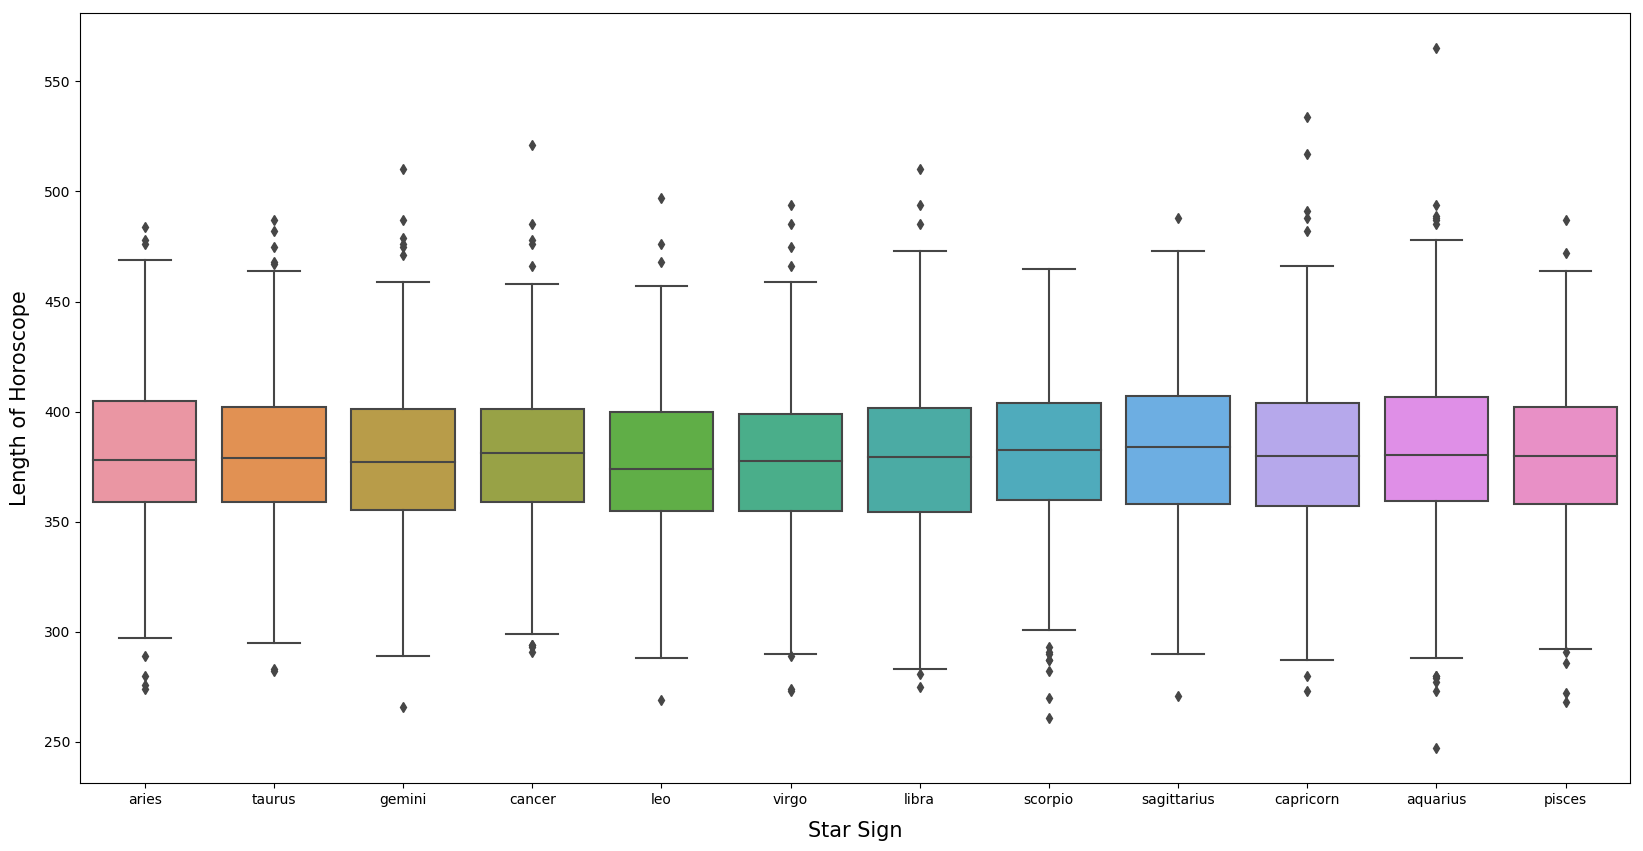

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(20,10))
ax = sns.boxplot(x="star_sign", y="length_horoscope", data=data)
plt.xlabel('Star Sign', fontsize=15, labelpad=10)
plt.ylabel('Length of Horoscope', fontsize=15, labelpad=10)

#### Now, there doesn't seem to be any huge discrepancy in terms of horoscope lengths between starsigns and the distributions seem quite close - atleast the astrologer seems to be consistent

#### Let's now check how the average horoscope length changes as a function of time - maybe people need more advice at certain times of the year or , alternatively, maybe the astrologer might hit a lazy bump.

In [9]:
# We have the date fields in differnt columns so let's make a new field to hold the date as a datetime object

data['datetime'] = pd.to_datetime(data[['day','year','month']])
data.head()

,day,horoscope,month,star_sign,year,length_horoscope,datetime
0,26,You're often preoccupied by other people's liv...,9,aries,2017,310,2017-09-26
1,27,Remind yourself of all the positive things you...,9,aries,2017,356,2017-09-27
2,28,"Your mind is especially keen today, Aries. You...",9,aries,2017,368,2017-09-28
3,29,Purchases for your home might be one of your p...,9,aries,2017,362,2017-09-29
4,30,A powerful creative urge may come upon you tod...,9,aries,2017,362,2017-09-30


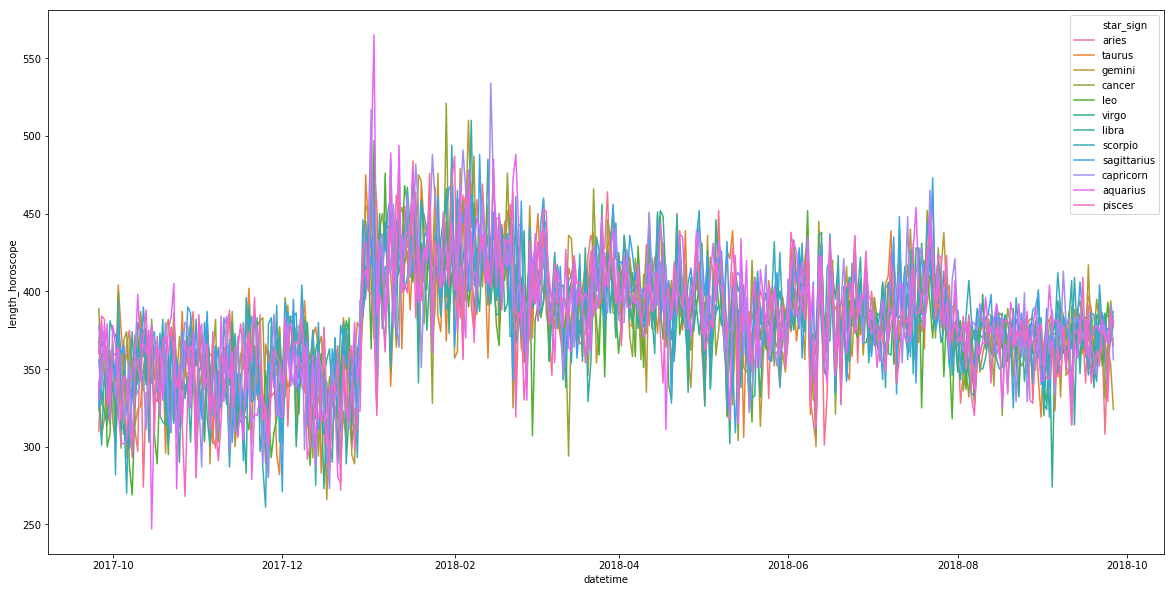

In [10]:
# Let's plot how length of the horoscope across all starsigns varies with time - let's add smoothing to remove the noise
plt.figure(figsize=(20,10))

sns.lineplot(x="datetime", y="length_horoscope", hue="star_sign", data=data)

#### Too chaotic as expected so let's try to get a monthly trend across all starsigns


In [11]:


len_by_month = data.groupby(pd.Grouper(key='datetime', freq='M'))
len_by_month.size().head(12)

datetime
2017-09-30     60
2017-10-31    372
2017-11-30    360
2017-12-31    372
2018-01-31    372
2018-02-28    336
2018-03-31    372
2018-04-30    360
2018-05-31    372
2018-06-30    360
2018-07-31    372
2018-08-31    372
Freq: M, dtype: int64

#### Right number of entries per month here, so grouping worked as expected - let's see which months have the longest average length across all starsigns (predicition is January)

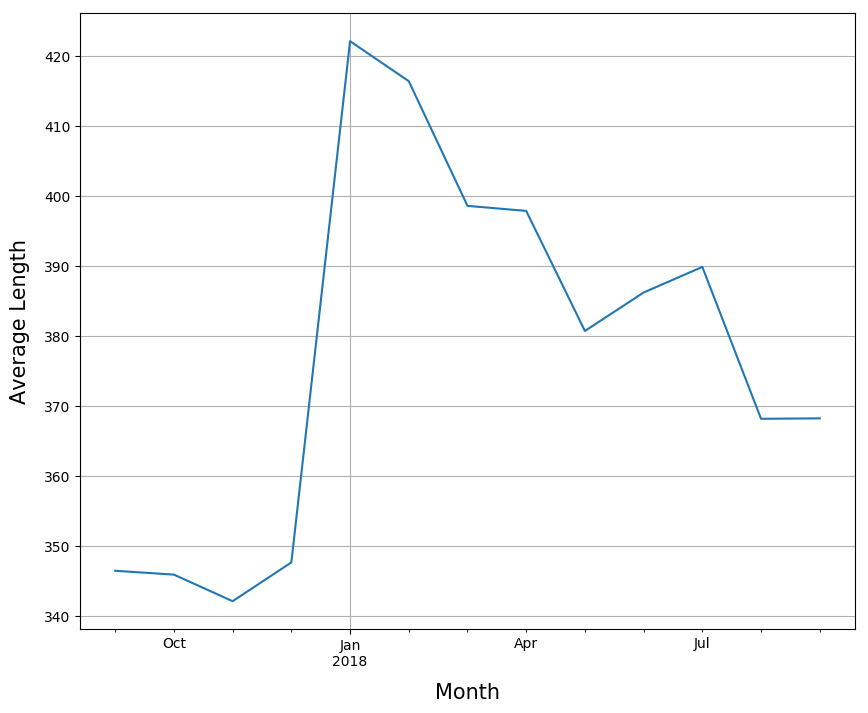

In [181]:
len_by_month.length_horoscope.mean().plot(kind='line',grid=True,figsize=[10,8])
plt.xlabel('Month', fontsize=15, labelpad=10)
plt.ylabel('Average Length', fontsize=15, labelpad=10)
plt.show()

#### As expected, the average length of horoscopes seems to peak around January (when most people presumably take up reading horoscopes) and gradually whittles down towards December (as people lose interest).

## Time for some lexical analysis

In [13]:
import nltk


#### Our first task is to tokenize the horoscopes for each entry and remove stop words - stemming is not required right now

In [14]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

# Let's try on a particular horoscope
random_horoscope = data.loc[20].horoscope

word_tokens = word_tokenize(random_horoscope)
print(len(word_tokens))
filtered = [w for w in word_tokens if w not in stop_words]
print(len(filtered))
print(word_tokens)
print(filtered)

74
49
['Cupid', 'may', 'have', 'struck', 'you', 'unawares', '.', 'Your', 'libido', 'could', 'be', 'in', 'high', 'gear', 'today', 'and', 'you', "'re", 'ready', 'for', 'love', '.', 'You', 'look', 'and', 'feel', 'great', '.', 'Try', 'your', 'best', 'to', 'reach', 'the', 'one', 'you', 'love', '.', 'If', 'it', 'is', "n't", 'possible', 'to', 'get', 'together', 'this', 'evening', ',', 'see', 'if', 'you', 'can', 'plan', 'a', 'romantic', 'interlude', 'soon', '.', 'If', 'all', 'else', 'fails', ',', 'dive', 'into', 'a', 'romance', 'novel', 'and', 'escape', 'that', 'way', '.']
['Cupid', 'may', 'struck', 'unawares', '.', 'Your', 'libido', 'could', 'high', 'gear', 'today', "'re", 'ready', 'love', '.', 'You', 'look', 'feel', 'great', '.', 'Try', 'best', 'reach', 'one', 'love', '.', 'If', "n't", 'possible', 'get', 'together', 'evening', ',', 'see', 'plan', 'romantic', 'interlude', 'soon', '.', 'If', 'else', 'fails', ',', 'dive', 'romance', 'novel', 'escape', 'way', '.']


In [15]:
# Punctuation and word endings like "'re" are also tokenized which we don't want so let's filter those out too
import re

punctuation = ['.',',','\'',':','!','?',';']
filtered = [w for w in word_tokens if ((w not in (list(stop_words)+punctuation)) and (not(bool(re.match("\'[a-z]{1,3}", w)))))]
print(filtered)

['Cupid', 'may', 'struck', 'unawares', 'Your', 'libido', 'could', 'high', 'gear', 'today', 'ready', 'love', 'You', 'look', 'feel', 'great', 'Try', 'best', 'reach', 'one', 'love', 'If', "n't", 'possible', 'get', 'together', 'evening', 'see', 'plan', 'romantic', 'interlude', 'soon', 'If', 'else', 'fails', 'dive', 'romance', 'novel', 'escape', 'way']


In [16]:
# let's apply it to dataset now 
word_stop_words = set(stopwords.words('english'))
punctuation = ['.',',','\'',':','!','?',';']
all_stop_parameters = list(word_stop_words) + punctuation
def tokenize(row):
    word_tokens = word_tokenize(row.horoscope.lower())
    # changing all_stop_parameters to set for speed
    filtered = [w for w in word_tokens if ((w not in set(all_stop_parameters)) and (not(bool(re.match("\'[a-z]{1,3}", w)))))]
    return filtered

word_data = data.copy()
word_data['horoscope_tok'] = word_data.apply(tokenize,axis=1)
del word_data['horoscope']
word_data.head()

,day,month,star_sign,year,length_horoscope,datetime,horoscope_tok
0,26,9,aries,2017,310,2017-09-26,"[often, preoccupied, people, lives, devotion, ..."
1,27,9,aries,2017,356,2017-09-27,"[remind, positive, things, going, life, aries,..."
2,28,9,aries,2017,368,2017-09-28,"[mind, especially, keen, today, aries, find, c..."
3,29,9,aries,2017,362,2017-09-29,"[purchases, home, might, one, projects, today,..."
4,30,9,aries,2017,362,2017-09-30,"[powerful, creative, urge, may, come, upon, to..."


#### Let's see which words are most popular

In [17]:
# have to have a a single tokenized list to apply NLTK's freqdist
all_words = sum(word_data.horoscope_tok.tolist(),[])
len(all_words)

151478

#### Plotting 20 most common words

Text(0,0.5,'Count')

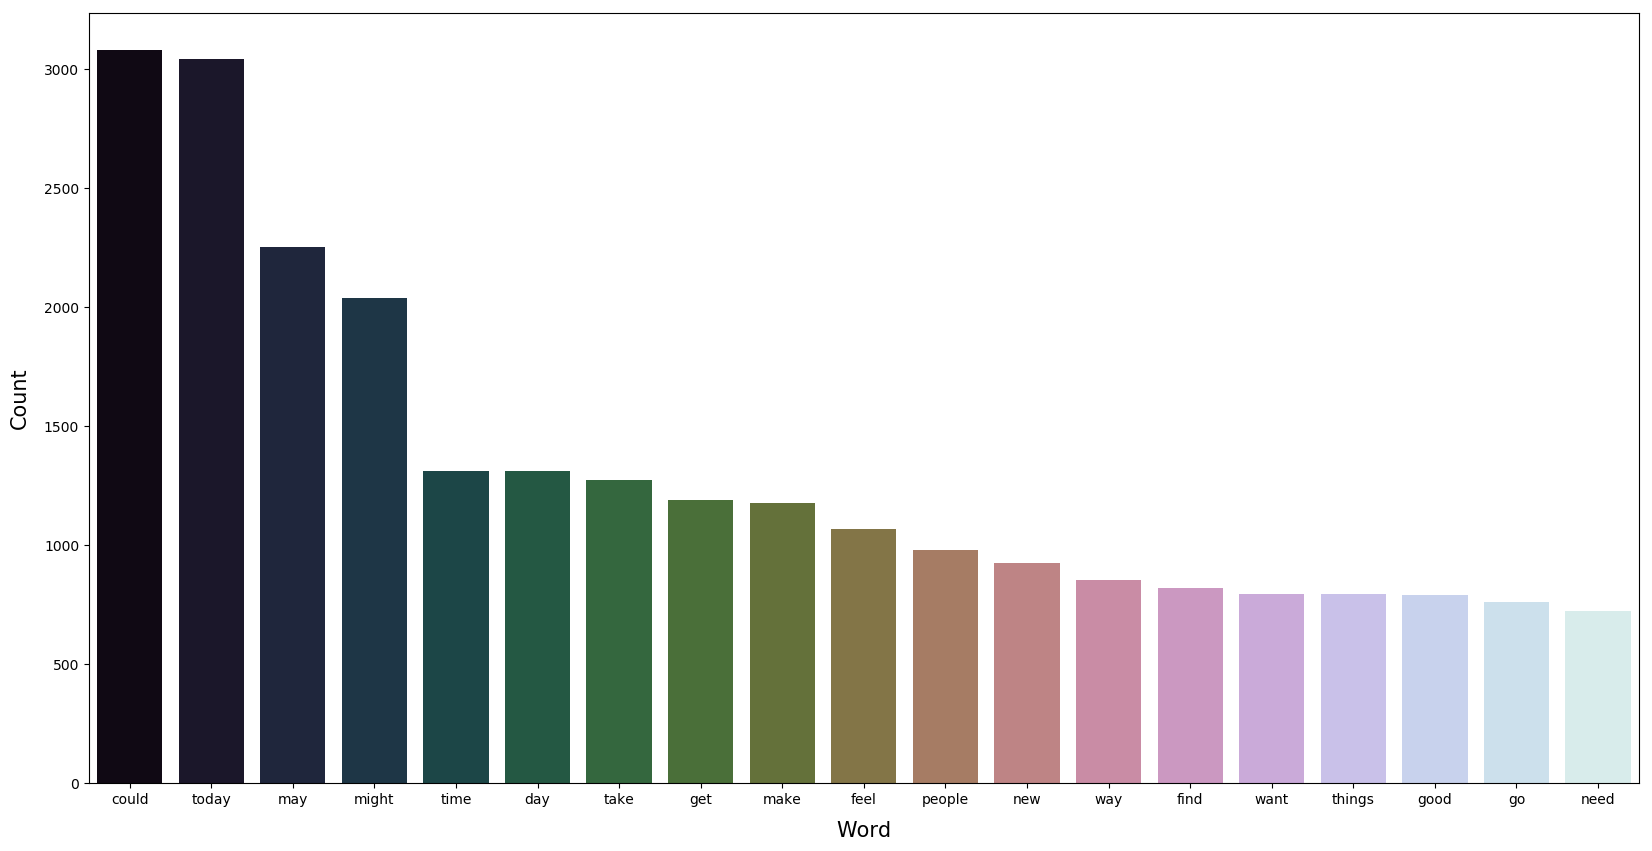

In [185]:
fdist_full = nltk.FreqDist(all_words)
most_common_words_full = fdist_full.most_common(20)
x_val, y_val = [x[0] for x in most_common_words_full], [x[1] for x in most_common_words_full]
plt.figure(figsize=(20,10))
# using x_val[1:] because 'n't' is coming out as a token annoyingly and it's the most used token
sns.barplot(x=x_val[1:],y=y_val[1:], palette = sns.color_palette("cubehelix", 20))
plt.xlabel('Word', fontsize=15, labelpad=10)
plt.ylabel('Count', fontsize=15, labelpad=10)

#### Can't really tell much from this as these just seem like any other word. Nothing about these words seems particular to horoscopes. An interesting thing to note though is roughly two groups (2000+ count) and sub 1500 count words. In the former group, three of the words are to do with uncertainty - 'could', 'may', 'might'. This fits in with the theory that horoscopes may just be written so that people experience something happen in the day and associate it with what the horoscope predicted 'might' happen.

#### Do the top 10 most popular words vary based on the month?

In [19]:
# let's groupby month again and perform the same analysis

word_data_by_month = word_data.groupby(pd.Grouper(key='datetime', freq='M')).horoscope_tok.sum()
top_words_by_month = word_data_by_month.apply(lambda x: nltk.FreqDist(x).most_common(10))
top_words_by_month


datetime
2017-09-30    [(n't, 44), (may, 43), (today, 42), (could, 37...
2017-10-31    [(may, 257), (n't, 242), (could, 228), (today,...
2017-11-30    [(n't, 244), (could, 242), (may, 237), (today,...
2017-12-31    [(n't, 275), (may, 259), (today, 244), (could,...
2018-01-31    [(could, 333), (today, 281), (might, 281), (n'...
2018-02-28    [(today, 286), (could, 271), (n't, 202), (’, 2...
2018-03-31    [(could, 318), (today, 287), (n't, 272), (migh...
2018-04-30    [(could, 392), (n't, 309), (today, 262), (migh...
2018-05-31    [(n't, 245), (today, 227), (may, 172), (could,...
2018-06-30    [(today, 274), (could, 260), (n't, 248), (migh...
2018-07-31    [(n't, 285), (today, 256), (may, 195), (could,...
2018-08-31    [(n't, 288), (today, 254), (could, 243), (may,...
2018-09-30    [(could, 260), (n't, 222), (may, 212), (today,...
Freq: M, Name: horoscope_tok, dtype: object

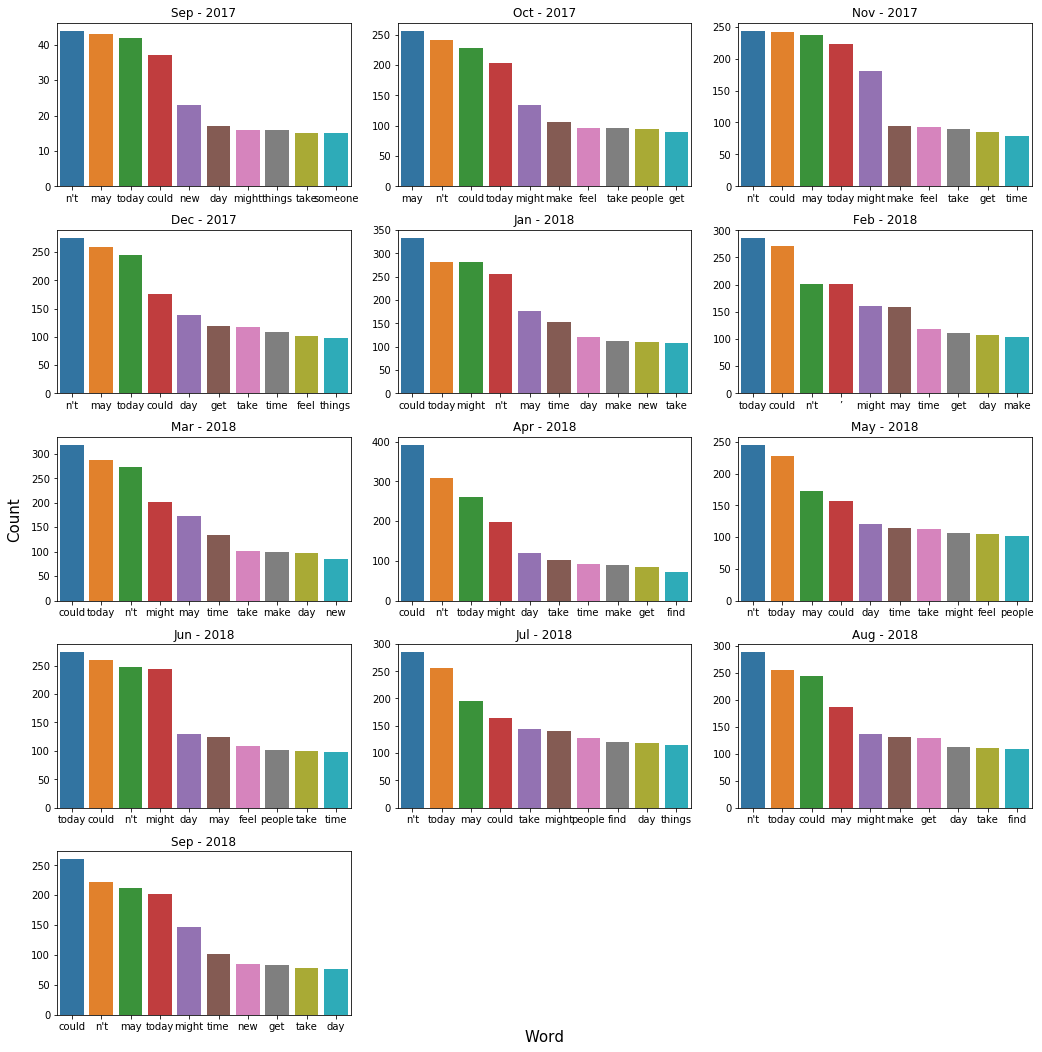

In [20]:
# time to make plots for each month

# let's reindex so we can loop through entries in top_words_by_month

top_words_by_month_ind = top_words_by_month.reset_index()
fig = plt.figure(figsize=(15,15))
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Word', fontsize=15, labelpad=15)
plt.ylabel('Count', fontsize=15, labelpad=35)

for i in range(0,13):
    data = top_words_by_month_ind.loc[i]
    ax = fig.add_subplot(5, 3, i+1, title = data.datetime.strftime('%b - %Y'))
    x_data, y_data = [x[0] for x in data.horoscope_tok], [x[1] for x in data.horoscope_tok]
    plt.xticks(rotation=45) 
    ax = sns.barplot(x=x_data, y=y_data)
    
    
plt.tight_layout()    
plt.show()    
    
    




#### Interesting, regardless of the month the author seems to use roughly the same top 10 words. Perhaps it's the style of the author - doing the same analysis but by starsign should hopefully reveal more insight.

In [21]:
word_data_by_sign = word_data.groupby('star_sign').horoscope_tok.sum()
top_words_by_sign = word_data_by_sign.apply(lambda x: nltk.FreqDist(x).most_common(10))
top_words_by_sign

star_sign
aquarius       [(could, 274), (aquarius, 264), (today, 253), ...
aries          [(could, 265), (aries, 263), (today, 250), (n'...
cancer         [(could, 273), (cancer, 264), (today, 260), (n...
capricorn      [(capricorn, 266), (today, 254), (n't, 251), (...
gemini         [(n't, 278), (could, 273), (gemini, 260), (tod...
leo            [(today, 262), (leo, 260), (n't, 259), (could,...
libra          [(n't, 270), (libra, 266), (could, 258), (toda...
pisces         [(today, 267), (could, 261), (pisces, 259), (n...
sagittarius    [(sagittarius, 266), (n't, 255), (today, 250),...
scorpio        [(n't, 280), (scorpio, 261), (today, 259), (co...
taurus         [(n't, 275), (taurus, 262), (could, 247), (tod...
virgo          [(n't, 291), (virgo, 265), (could, 251), (toda...
Name: horoscope_tok, dtype: object

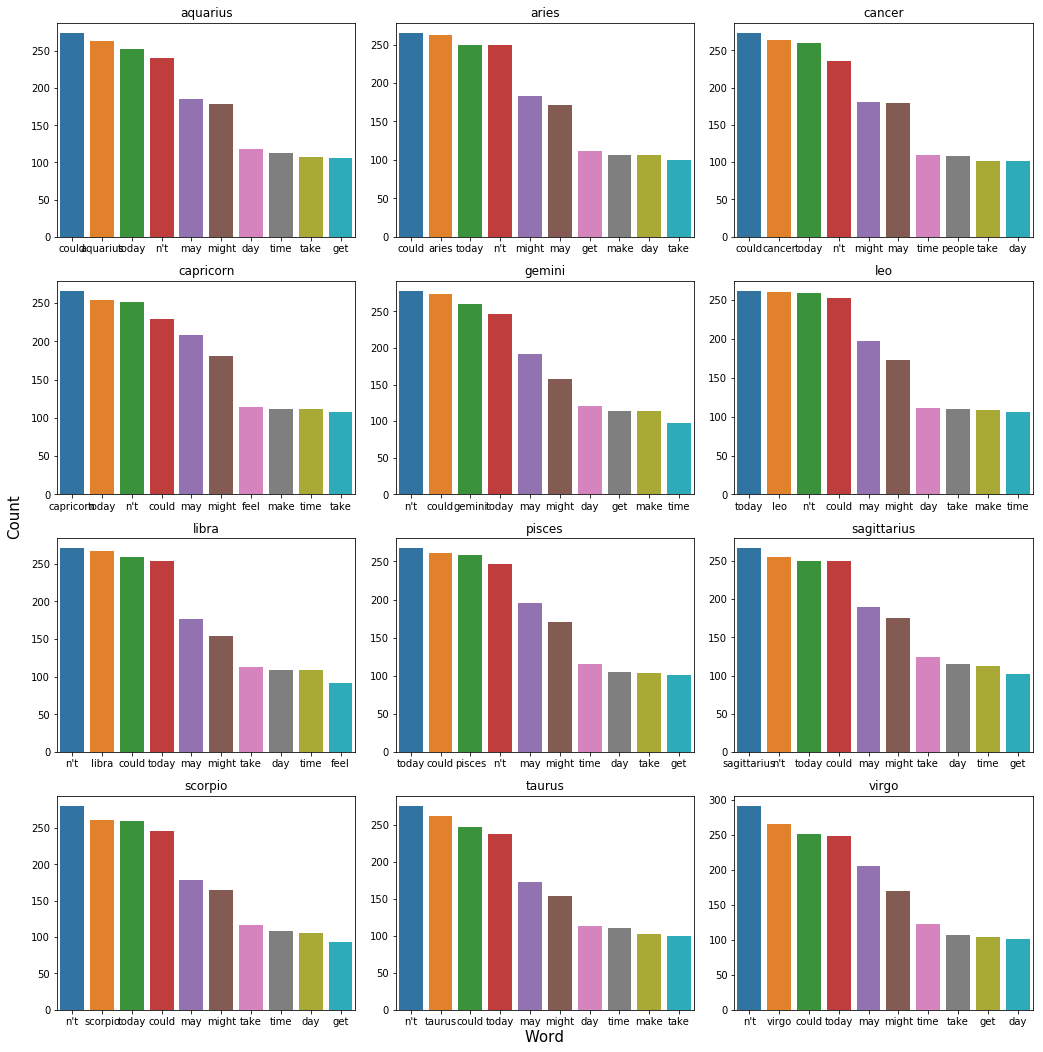

In [22]:

top_words_by_sign_ind = top_words_by_sign.reset_index()
fig = plt.figure(figsize=(15,15))
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Word', fontsize=15,labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=35)

for i in range(0,12):
    data = top_words_by_sign_ind.loc[i]
    ax = fig.add_subplot(4, 3, i+1, title = data.star_sign)
    x_data, y_data = [x[0] for x in data.horoscope_tok], [x[1] for x in data.horoscope_tok]
    plt.xticks(rotation=45) 
    ax = sns.barplot(x=x_data, y=y_data)
    
    
plt.tight_layout()    
plt.show() 

#### Here, I expected to see a clear difference in the words used between starsigns as otherwise - what makes the horoscopes unique? However, with the exception of the inclusion of the respective starsign in the top words, the distribution is more or less the same across star signs as it is across months. 

#### After thinking why this might be the case, I thought that perhaps the writing style of the author is highly unvariable and these top words are just due to the nature of their writing. To account for this, let's use a different metric than word count.

#### Let's try using tf-idf (term-frequency inverse document-frequency) so that hopefully all the words like 'today' and 'might' get downweighted which will allow us to get a better look at the distribution of words across months and signs.

In [192]:
# We need to calculate the td-idf values for each word in each starsign's horoscope_tok.sum()
# and then we can sort them by value

# Going to use countvectorizer first
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# need to convert word_data_by_sign from list to string
word_data_by_sign_str = word_data_by_sign.apply(lambda x: ' '.join(x))

# setting max_df to 11 to get rid of 'may' 'might' etc
cvec = CountVectorizer(min_df=1, max_df=11)
cvec.fit(word_data_by_sign_str)
len(cvec.vocabulary_)

8428

In [193]:
# ok 8428 words, let's now see how many times they occur in each document

cvec_counts = cvec.transform(word_data_by_sign_str)
cvec_counts.shape

(12, 8428)

In [194]:
# just to confirm we did this right, let's see what thetop words are - should be the star signs I predict
total_occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
total_counts = pd.DataFrame({'word': cvec.get_feature_names(), 'occurrences': total_occ})
total_counts.sort_values(by='occurrences', ascending=False).head(10)

,word,occurrences
4330,libra,266
6462,sagittarius,266
1046,capricorn,266
8112,virgo,265
396,aquarius,264
1027,cancer,264
408,aries,263
7474,taurus,262
6543,scorpio,261
4309,leo,260


In [195]:
# Yay, seems like we did it the right way
# let's now get td-idf weights

weight_calculator = TfidfTransformer()
tf_idf = weight_calculator.fit_transform(cvec_counts)
tf_idf

<12x8428 sparse matrix of type '<class 'numpy.float64'>'
	with 27085 stored elements in Compressed Sparse Row format>

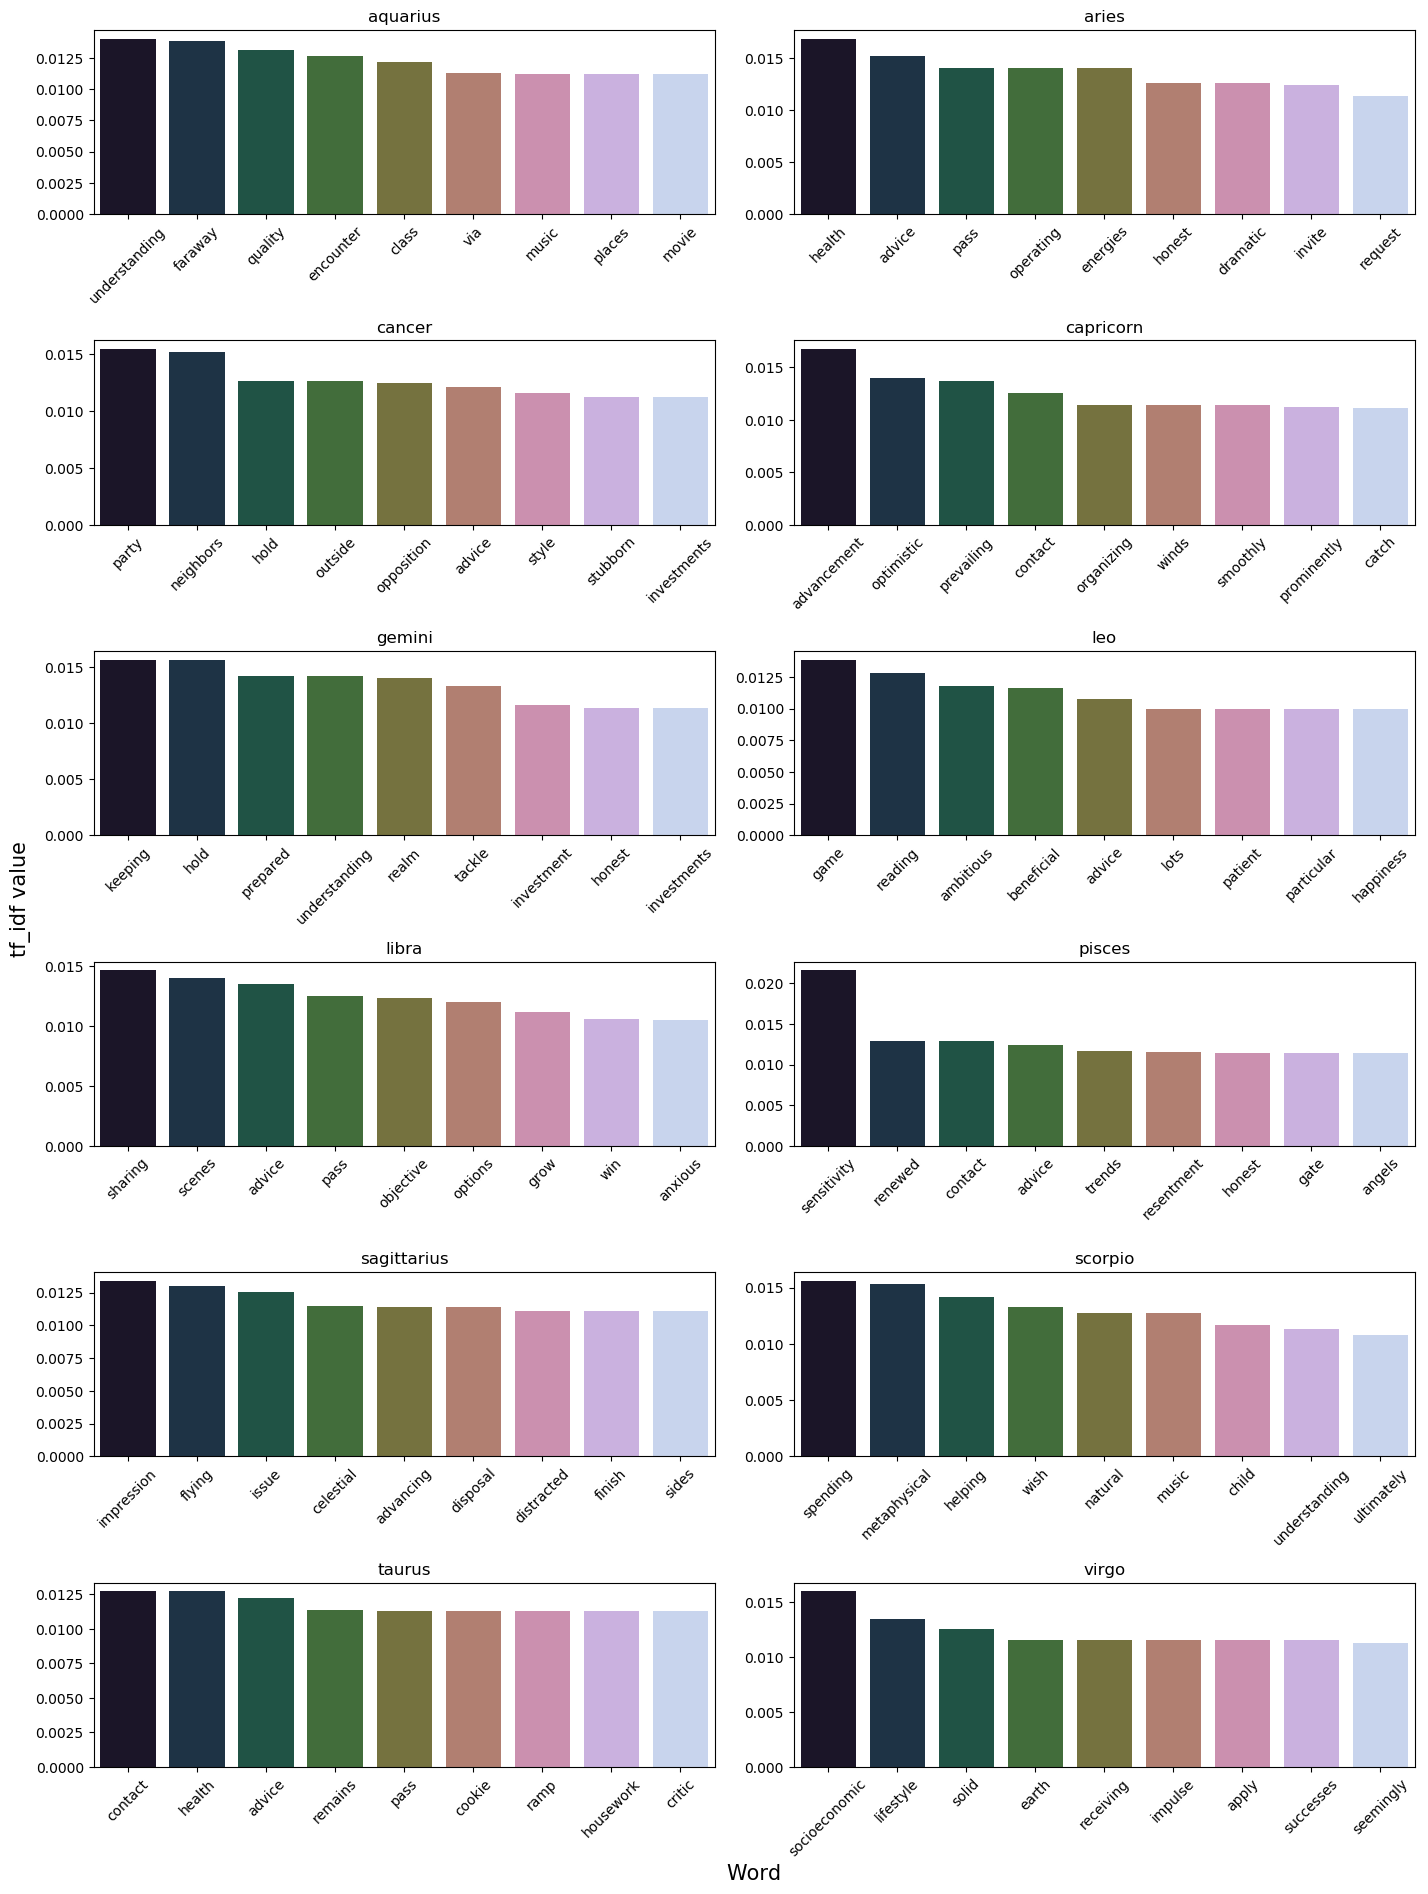

In [202]:
# ok, now to plot a graph of the top words ordered by tf_idf for each star_sign

#first let's make sparse matrix dense cause I don't know how to work with sparse matrices

tf_idf_dense = np.asarray(tf_idf.todense())
fig = plt.figure(figsize=(15,20))
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Word', fontsize=15,labelpad=70)
plt.ylabel('tf_idf value', fontsize=15, labelpad=45)
star_signs = word_data_by_sign_str.index.values

for i in range(0,12):
    data = tf_idf_dense[i]
    # get indices of top 10 tf_idf weighted words the starsign
    word_indices = data.argsort()[-10:][::-1].tolist()
    # now get actual values of tf_idf
    values = sorted(data)[-10:][::-1]
    #now map indices to actual words
    words = [cvec.get_feature_names()[x] for x in word_indices]
    ax = fig.add_subplot(6, 2, i+1, title = star_signs[i])
    # it was found that the td_idf values for the star sign word itself
    # e.g. 'taurus' was so high relative to other words that plotting does not 
    # look nice so let's remove that
    x_data = words[1:]
    y_data = values[1:]
    plt.xticks(rotation=45) 
    ax = sns.barplot(x=x_data, y=y_data, palette = sns.color_palette("cubehelix", 10))
    
    
plt.tight_layout()    
plt.show() 


#### Note that in the above graphs, the actual star sign words, e.g. 'taurus', were removed as they always had the highest tf_idf values and very high relative value made the graphs unsightly.

#### Alright, now this is much more useful than the most frequently used words. Each starsign has a different set of top words ranked by tf-idf and so we can use these words as an identifier for each starsign.

### One thing we could do now is calculate a cosine similarity metric between all pairs of star-signs based on their tf-idf vectors. In doing this, we attempt to measure how similar different star-signs are and we can compare this to what the astrologers say. If in fact the two findings match, maybe can we afford to give the astrologer some legitness points. 

In [203]:
from sklearn.metrics.pairwise import linear_kernel

# tf-idf matrix is already row-normalised so can go straight to dot product

cosine_similarities = linear_kernel(tf_idf_dense,tf_idf_dense)

# ok now find top pairings per starsign (let's get top two just to be safe)

pairings = {}

for i in range(0,12):
    current_sign = star_signs[i]
    sign_similarities = cosine_similarities[i]
    # the top similarity will always be the same sign so let's be sure to ignore that
    top_two_indices = sign_similarities.argsort()[-3:-1][::-1].tolist()
    # now to map those indices to star_signs
    top_two = [star_signs[x] for x in top_two_indices]
    pairings[current_sign] = top_two

print(pairings)

{'aquarius': ['gemini', 'sagittarius'], 'aries': ['taurus', 'cancer'], 'cancer': ['aries', 'gemini'], 'capricorn': ['gemini', 'aries'], 'gemini': ['taurus', 'cancer'], 'leo': ['cancer', 'virgo'], 'libra': ['gemini', 'virgo'], 'pisces': ['gemini', 'taurus'], 'sagittarius': ['gemini', 'aquarius'], 'scorpio': ['cancer', 'gemini'], 'taurus': ['aries', 'gemini'], 'virgo': ['gemini', 'scorpio']}


#### I expected the best pairings between starsigns to be the same across all astrologers and sites, but looking through the internet this seems to not be the case. Each website more or less gives a different pairing and often, they don't give a full list but rather provide a service in which you input two star signs and it outputs a compatibility match - that definietely seems not legit. 

#### Thus, to have a level of reliability (and give benefit of doubt to the astrologer that wrote the starsigns I'm analysing), let's use the best pairings from horoscope.com

In [111]:
# below are the 'true' love pairings as listed by horoscope.com

true_pairings = {'aries':['sagittarius'], 'libra':['gemini'], 'taurus':['cancer','virgo'],
                'scorpio':['cancer'], 'gemini':['aries','leo'], 'sagittarius':['aries'],
                'cancer':['taurus','pisces'], 'capricorn':['virgo'], 'leo':['libra'],
                'aquarius':['libra','gemini'], 'virgo':['cancer'], 'pisces':['cancer']}

# now, the best possible score would be if our analysis pairings corresponded exactly with the 
# ones given by horoscope.com. Getting both pairings in the case of when horscope.com gives two
# options should not be a requisite, so we'll set the best score possible to 12.

best_score = 12
score = 0
for sign in star_signs:
    true_pairs = true_pairings[sign]
    predicted_pairs = pairings[sign]
    matches = [True for pair in true_pairs if pair in predicted_pairs]
    if any(matches):
        score+=1

prop_right = score/best_score
print('Proportion right:', prop_right)

Proportion right: 0.25


#### Quite a poor match between prediction and reality here. Considering that each horoscope site has different pairings, perhaps this isn't surprising. Perhaps the pairings have nothing to do how similar the horoscopes are the star signs and are dependent on something else.

#### As a last attempt to give merit to the validity of these horoscopes with regard to star sign compatibility, let's test the idea of opposites attract. Maybe compatible star signs will have very different horoscopes?

In [112]:
# let's do the same as before but now get the signs with the LEAST cosine similarity
opposite_pairings = {}

for i in range(0,12):
    current_sign = star_signs[i]
    sign_similarities = cosine_similarities[i]
    # the top similarity will always be the same sign so let's be sure to ignore that
    worst_two_indices = sign_similarities.argsort()[0:2].tolist()
    # now to map those indices to star_signs
    worst_two = [star_signs[x] for x in worst_two_indices]
    opposite_pairings[current_sign] = worst_two

print(opposite_pairings)

{'aquarius': ['leo', 'cancer'], 'aries': ['sagittarius', 'libra'], 'cancer': ['sagittarius', 'aquarius'], 'capricorn': ['leo', 'libra'], 'gemini': ['leo', 'aquarius'], 'leo': ['capricorn', 'sagittarius'], 'libra': ['capricorn', 'aries'], 'pisces': ['libra', 'leo'], 'sagittarius': ['cancer', 'leo'], 'scorpio': ['leo', 'capricorn'], 'taurus': ['leo', 'sagittarius'], 'virgo': ['capricorn', 'sagittarius']}


In [113]:

best_score = 12
score = 0
for sign in star_signs:
    true_pairs = true_pairings[sign]
    predicted_pairs = opposite_pairings[sign]
    matches = [True for pair in true_pairs if pair in predicted_pairs]
    if any(matches):
        score+=1

prop_right = score/best_score
print('Proportion right:', prop_right)

Proportion right: 0.16666666666666666


#### Alright, even worse than before. Time to abandon the compatibility idea for something that's potentially more fruitful.

## We've seen how the words used vary with the starsign - how about how they vary the month? Consider the trend we saw in the length of the horoscopes: namely how the length gradually decreases throughout the year until it shoots back up again in January when there is a sudden influx in readers One could hypothesize that maybe a similar trend occurs with the words used in the horoscopes. People want to feel captivated when reading their horoscope and what better way to retain readers at the start of the year than by using overly emotive language. Let's investigate.

In [118]:
# need to convert word_data_by_month from list to string
word_data_by_month_str = word_data_by_month.apply(lambda x: ' '.join(x))

# setting max_df to 11 to get rid of 'may' 'might' etc
cvec_month = CountVectorizer(min_df=1, max_df=11)
cvec_month.fit(word_data_by_month_str)
len(cvec_month.vocabulary_)

8411

In [119]:
## ok 8411 words, let's now see how many times they occur in each document

cvec_counts_month = cvec_month.transform(word_data_by_month_str)
cvec_counts_month.shape

(13, 8411)

In [120]:
# just to check we did it right, let's get top words - should be starsigns again
total_occ = np.asarray(cvec_counts_month.sum(axis=0)).ravel().tolist()
total_counts = pd.DataFrame({'word': cvec_month.get_feature_names(), 'occurrences': total_occ})
total_counts.sort_values(by='occurrences', ascending=False).head(10)

,word,occurrences
1037,capricorn,266
4318,libra,266
6443,sagittarius,266
8091,virgo,265
389,aquarius,264
1018,cancer,264
400,aries,263
7455,taurus,262
6525,scorpio,261
3209,gemini,260


In [121]:
# let's now get td-idf weights

weight_calculator_month = TfidfTransformer()
tf_idf_month = weight_calculator_month.fit_transform(cvec_counts_month)
tf_idf_month

<13x8411 sparse matrix of type '<class 'numpy.float64'>'
	with 26462 stored elements in Compressed Sparse Row format>

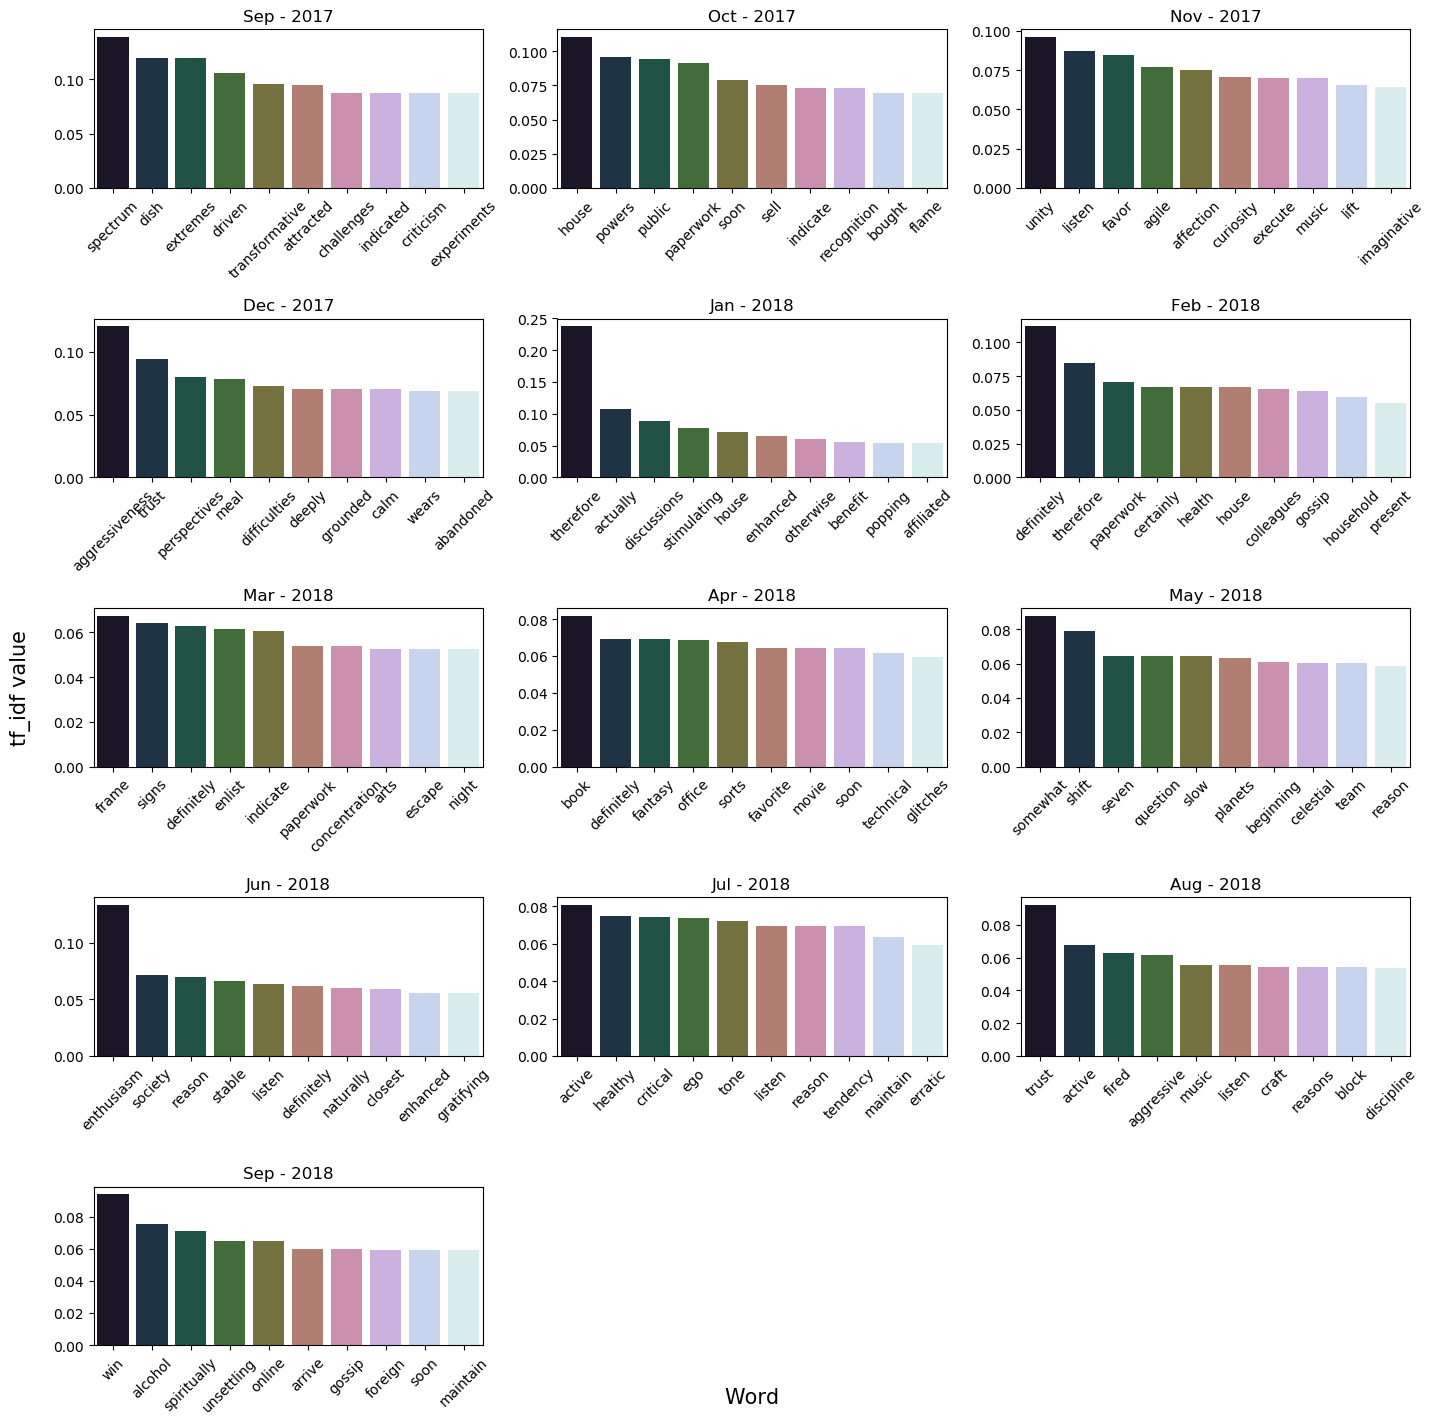

In [171]:
# ok, now to plot a graph of the top words ordered by tf_idf for each month

#first let's make sparse matrix dense cause I don't know how to work with sparse matrices

tf_idf_dense_month = np.asarray(tf_idf_month.todense())
fig = plt.figure(figsize=(15,15))
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Word', fontsize=15,labelpad=30)
plt.ylabel('tf_idf value', fontsize=15, labelpad=45)
months = word_data_by_month_str.index.values



for i in range(0,13):
    data = tf_idf_dense_month[i]
    # get indices of top tf_idf weighted words the starsign
    word_indices = data.argsort()[-22:][::-1].tolist()
    # now get actual values of tf_idf
    values = sorted(data)[-22:][::-1]
    #now map indices to actual words
    words = [cvec_month.get_feature_names()[x] for x in word_indices]
    ax = fig.add_subplot(5, 3, i+1, title = pd.to_datetime(str(months[i])).strftime('%b - %Y'))
    # it was found that the td_idf values for the star sign words 
    # e.g. 'taurus' were often the top values. Need to remove these from our plots
    # however, not as easy as just removing top 12 words as the star signs aren't always the top words
    #let's first find indices of words where the star signs are
    star_signs_list = list(star_signs)
    indices = [i for i, e in enumerate(words) if e in star_signs_list]
    x_data =  [x for i,x in enumerate(words) if i not in indices]
    y_data = [x for i,x in enumerate(values) if i not in indices]
    #sns.set_palette(sns.color_palette("BuGn_r"))
    ax = sns.barplot(x=x_data[:10], y=y_data[:10], palette = sns.color_palette("cubehelix", 10))
    plt.xticks(rotation=45)    
plt.tight_layout()    
plt.show() 

